In [57]:
install.packages('dslabs')
install.packages('caret', dependencies = TRUE)
install.packages('tidyverse')

Installing package into ‘/home/user/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
Installing package into ‘/home/user/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
also installing the dependencies ‘bitops’, ‘httpuv’, ‘xtable’, ‘sourcetools’, ‘later’, ‘promises’, ‘spData’, ‘gdata’, ‘caTools’, ‘TH.data’, ‘profileModel’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘plotrix’, ‘shiny’, ‘miniUI’, ‘classInt’, ‘labelled’, ‘gplots’, ‘multcomp’, ‘brglm’, ‘gtools’, ‘lme4’, ‘qvcalc’, ‘plotmo’, ‘TeachingDemos’, ‘combinat’, ‘questionr’, ‘ROCR’, ‘mvtnorm’, ‘modeltools’, ‘strucchange’, ‘coin’, ‘zoo’, ‘sandwich’, ‘ISwR’, ‘corpcor’, ‘praise’, ‘BradleyTerry2’, ‘e1071’, ‘earth’, ‘fastICA’, ‘gam’, ‘klaR’, ‘ellipse’, ‘mda’, ‘mlbench’, ‘MLmetrics’, ‘party’, ‘pROC’, ‘proxy’, ‘randomForest’, ‘RANN’, ‘spls’, ‘subselect’, ‘pamr’, ‘superpc’, ‘Cubist’, ‘testthat’

Installing package into ‘/home/user/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)


In [58]:
library('dslabs')
library('caret')
library('tidyverse')

In [59]:
data("heights")

In [60]:
y <- heights$sex
x <- heights$height

In [61]:
set.seed(2)
test_index <- createDataPartition(y, times = 1, p = 0.5, list = FALSE)

train_set <- heights[-test_index,]
test_set <- heights[test_index,]

Approach 1: Guessing

In [62]:
y_hat <- sample(c('Male','Female'),length(test_index),replace=TRUE) %>% factor(levels = levels(test_set$sex))

mean(y_hat == test_set$sex)

[1] 0.4628571

Approach 2: Cut-Off

In [63]:
heights %>% group_by(sex) %>% summarize(mean(height), sd(height))

sex,mean(height),sd(height)
Female,64.93942,3.760656
Male,69.31475,3.611024


In [64]:
y_hat <- ifelse(x > 62, 'Male', 'Female') %>% factor(levels = levels(test_set$sex))

mean(y_hat == test_set$sex)

[1] 0.7228571

In [65]:
cutoff <- seq(61,70)
accuracy <- map_dbl(cutoff, function(x){
    y_hat <- ifelse(train_set$height > x, 'Male','Female') %>%
    factor(levels = levels(test_set$sex))
    mean(y_hat == train_set$sex)
})

[1] 0.8361905

[1] 64

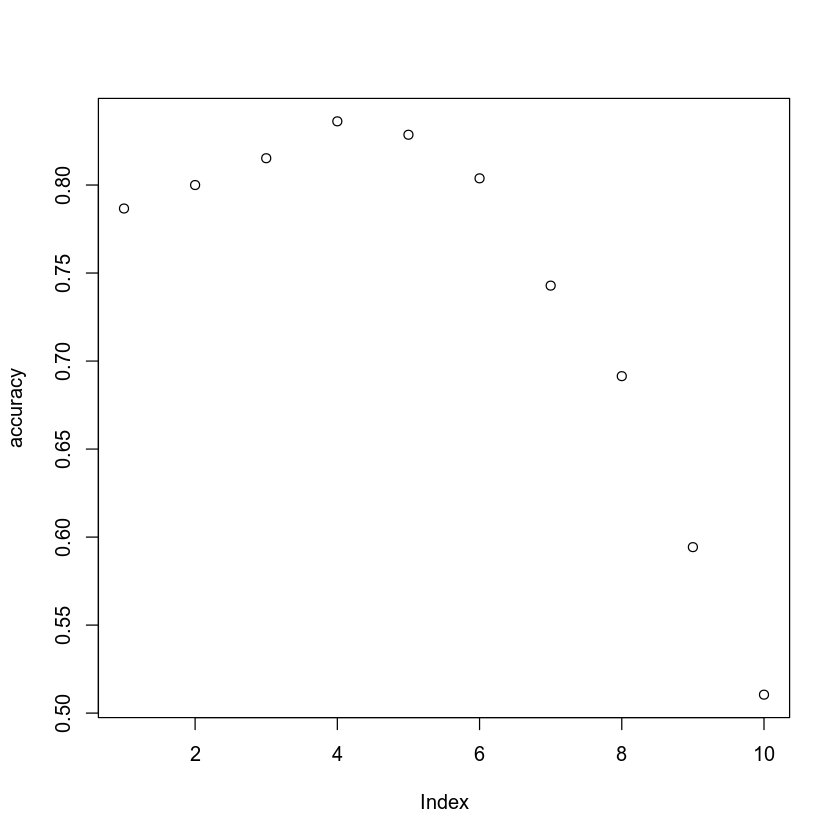

In [66]:
plot(accuracy)
max(accuracy)
best_cutoff <- cutoff[which.max(accuracy)]
best_cutoff

In [67]:
y_hat <- ifelse(test_set$height > best_cutoff,'Male','Female') %>%
factor(levels = levels(test_set$sex))
y_hat <- factor(y_hat)
mean(y_hat == test_set$sex)

[1] 0.8171429

Confusion Matrix

In [68]:
table(predicted = y_hat, actual = test_set$sex)

         actual
predicted Female Male
   Female     50   27
   Male       69  379

In [69]:
test_set %>%
mutate(y_hat = y_hat) %>%
group_by(sex) %>%
summarize(accuracy = mean(y_hat == sex))

prev <- mean(y == 'Male')
prev

sex,accuracy
Female,0.4201681
Male,0.9334975


[1] 0.7733333

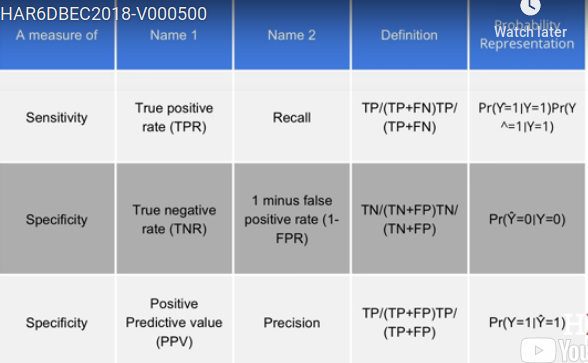

In [70]:
confusionMatrix(data = y_hat, reference = test_set$sex)

Confusion Matrix and Statistics

          Reference
Prediction Female Male
    Female     50   27
    Male       69  379
                                          
               Accuracy : 0.8171          
                 95% CI : (0.7814, 0.8493)
    No Information Rate : 0.7733          
    P-Value [Acc > NIR] : 0.008354        
                                          
                  Kappa : 0.4041          
 Mcnemar's Test P-Value : 2.857e-05       
                                          
            Sensitivity : 0.42017         
            Specificity : 0.93350         
         Pos Pred Value : 0.64935         
         Neg Pred Value : 0.84598         
             Prevalence : 0.22667         
         Detection Rate : 0.09524         
   Detection Prevalence : 0.14667         
      Balanced Accuracy : 0.67683         
                                          
       'Positive' Class : Female          
                                          

Balanced Accuary, F1 Score

In [72]:
cutoff <- seq(61,70)
F_1 <- map_dbl(cutoff, function(x){
    y_hat <- ifelse(train_set$height > x, 'Male','Female') %>%
    factor(levels = levels(test_set$sex))
    F_meas(data = y_hat, reference = factor(train_set$sex))
})

[1] 0.6142322

[1] 66

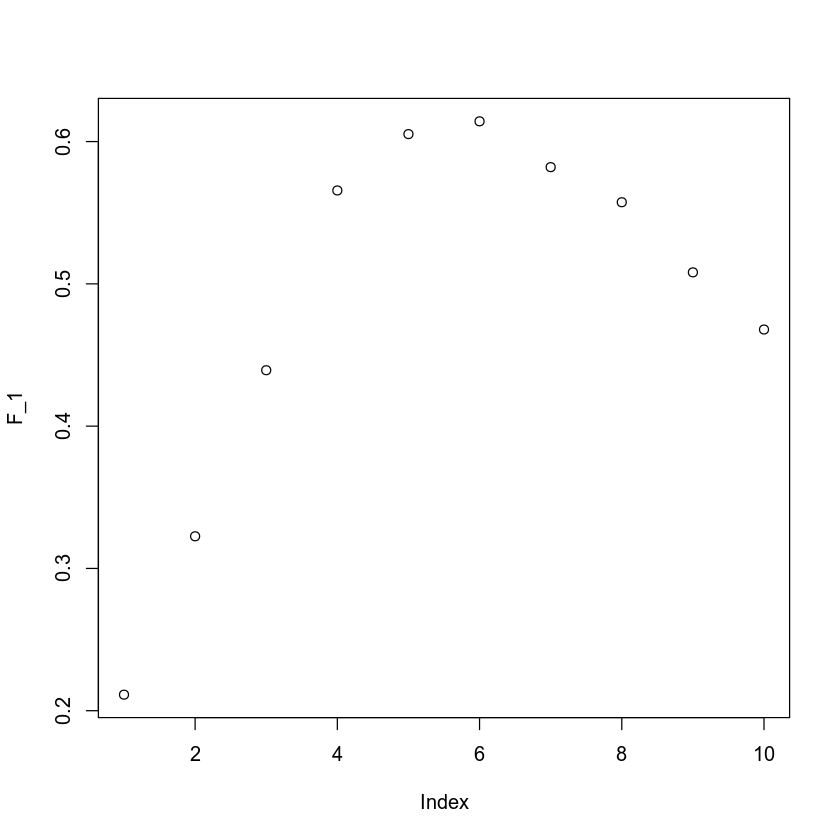

In [73]:
plot(F_1)
max(F_1)
best_cutoff <- cutoff[which.max(F_1)]
best_cutoff

ROC curve

In [89]:
cutoffs <- c(50,seq(60,75),80)
height_cutoff <- map_df(cutoffs, function(x){
    y_hat <- ifelse(train_set$height > x, 'Male','Female') %>%
    factor(levels = c('Female','Male'))
    list(method = 'Height cutoff',
        FPR = 1-specificity(y_hat,test_set$sex),
        TPR = sensitivity(y_hat, test_set$sex))
})

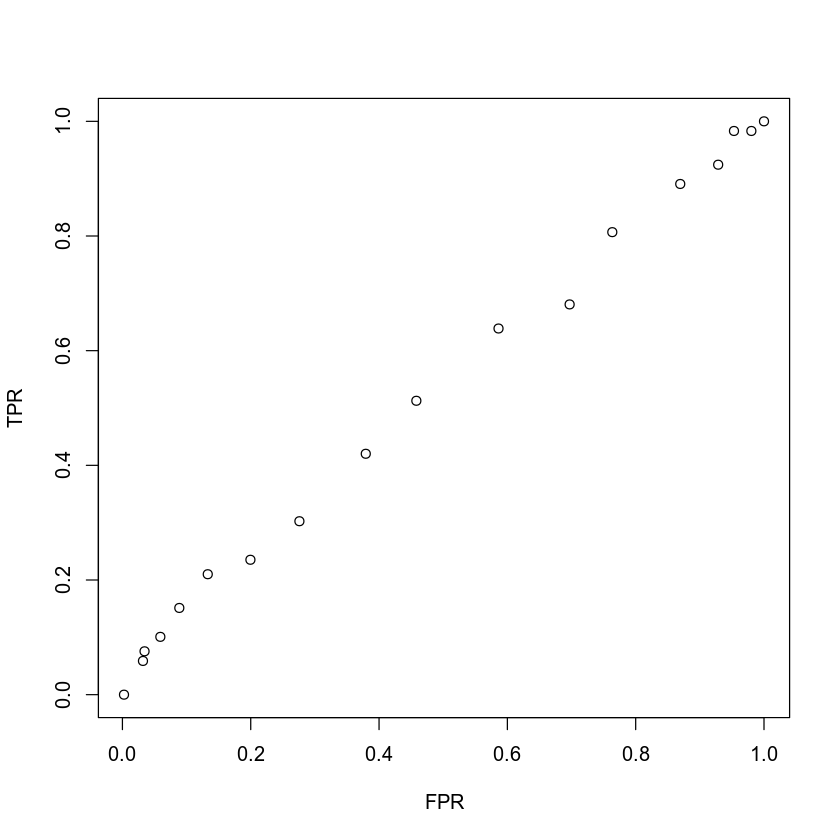

In [87]:
plot(height_cutoff[c(2,3)])

In [91]:
probs <- c(0,seq(0.1,0.9),1)
cutoffs <- c(50,seq(60,75),80)

guessing <- map_df(probs, function(p){
    y_hat <- sample(c('Male','Female'),length(test_index), replace=TRUE, prob=c(p,1-p)) %>%#ifelse(train_set$height > x, 'Male','Female') %>%
    factor(levels = c('Female','Male'))
    list(method = 'Guess',
        recall = sensitivity(y_hat,test_set$sex),
        precision = precision(y_hat, test_set$sex))
})

height_cutoff <- map_df(cutoffs, function(x){
    y_hat <- ifelse(train_set$height > x, 'Male','Female') %>%
    factor(levels = c('Female','Male'))
    list(method = 'Height cutoff',
        recall = sensitivity(y_hat,test_set$sex),
        precision = precision(y_hat, test_set$sex))
})